In [21]:
# Customer Retention & Revenue Risk Analysis

##Context
#This project analyzes customer transaction data to identify early signs of customer disengagement and quantify potential revenue at risk due to declining purchase behavior.

## Objective
#- Detect customers showing declining engagement
#- Estimate revenue exposed to churn risk
#- Segment customers based on behavioral metrics
#- Provide actionable retention recommendations

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
df = pd.read_csv("/content/online_retail_II.csv")

In [24]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [25]:
df_raw = df.copy()


In [26]:
df.shape

(1067371, 8)

In [28]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
analysis_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [29]:
df["InvoiceDate"].dtype


dtype('<M8[ns]')

In [30]:
df["Revenue"] = df["Quantity"] * df["Price"]


In [31]:
rfm = (
    df.groupby('Customer ID')
      .agg({
          'InvoiceDate': lambda x: (analysis_date - x.max()).days,
          'Invoice': 'nunique',
          'Revenue': 'sum'
      })
      .reset_index()
)
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [32]:
rfm.shape

(5942, 4)

In [33]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,17,-64.68
1,12347.0,2,8,5633.32
2,12348.0,75,5,2019.40
3,12349.0,19,5,4404.54
4,12350.0,310,1,334.40


In [34]:
recency_q50 = rfm["Recency"].quantile(0.50)
recency_q75 = rfm["Recency"].quantile(0.75)
frequency_q50 = rfm["Frequency"].quantile(0.50)


In [35]:
def seg_customer(row):
    if row["Recency"] <= recency_q50 and row["Frequency"] > frequency_q50:
        return "Loyal"
    elif row["Recency"] > recency_q75:
        return "Dormant"
    else:
        return "At Risk"
rfm["Segment"] = rfm.apply(seg_customer, axis=1)


In [36]:
seg_summary = (
    rfm.groupby("Segment")
       .agg({
           "CustomerID": "count",
           "Monetary": "sum"
       })
       .reset_index()
)
seg_summary


,Segment,CustomerID,Monetary
0,At Risk,2637,2.925005e+06
1,Dormant,1482,8.029710e+05
2,Loyal,1823,1.292032e+07


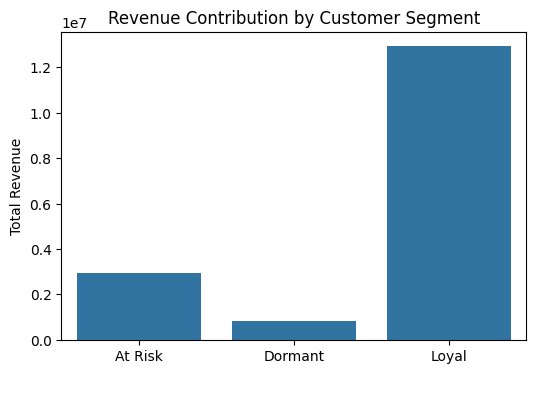

In [37]:
plt.figure(figsize=(6,4))
sns.barplot(data=seg_summary, x="Segment", y="Monetary")
plt.title("Revenue Contribution by Customer Segment")
plt.ylabel("Total Revenue")
plt.xlabel(" ")
plt.show()


In [ ]:
#logic:
#Customers were segmented using recency and frequency metrics with quantile-based thresholds.
#This approach enables explainable categorization into Loyal, At Risk ans Dormant groups,
#supporting targeted retention and reactivation strategies.
